In [44]:
# !pip install catboost
# !pip install yellowbrick
# !pip install ipywidgets
# !pip install pandas-profiling

In [45]:
# !jupyter nbextension enable --py widgetsnbextension

In [46]:
import os
import random
import sqlite3
import datetime

import numpy as np
import pandas as pd

import seaborn as sns
import pandas_profiling as pp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from scipy.stats import norm
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import catboost
import tensorflow as tf
from catboost import CatBoostRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

from sklearn.metrics import max_error
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae, explained_variance_score

from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error

%matplotlib inline

In [47]:
database = sqlite3.connect(os.path.join(os.getcwd(), "fypdbmain.sqlite"))

In [48]:
# tickers = {
#     "EVs": ["TSLA"],
#     "Finance": ["MS"],
#     "Tech": ["GOOGL"]
# }

# categories = ["EVs", "Finance","Tech"]
tickers = {
    "EVs": "TSLA",
    "Finance": "MS",
    "Tech": "GOOGL"
}

categories = ["EVs","Finance","Tech"]

tableName = {
    "EVs": "evDataAggr",
    "Finance": "financeDataAggr",
    "Tech": "techDataAggr"
}


In [49]:
def load_datasets(tickers, categories):
    tweet_dfs = dict()
    
    stock_dfs = dict()
    for category in categories:
      ticker = tickers[category]
      #ToDo make this line general
      tweet_df = pd.read_sql_query(f"SELECT * from {tableName[category]}",database)
      tweet_df = tweet_df.drop(columns = ['category'])
      tweet_df["date"] = tweet_df["date"].astype("datetime64")
      tweet_df["count"] = tweet_df["count"].astype("int32")
      tweet_df["neg_count"] = tweet_df["neg_count"].astype("int32")
      tweet_df["neu_count"] = tweet_df["neu_count"].astype("int32")
      tweet_df["pos_count"] = tweet_df["pos_count"].astype("int32")
      tweet_df["neg_score"] = tweet_df["neg_score"].astype("float64")
      tweet_df["neu_score"] = tweet_df["neu_score"].astype("float64")
      tweet_df["pos_score"] = tweet_df["pos_score"].astype("float64")
      tweet_df["wt_neg"] = tweet_df["wt_neg"].astype("float64")
      tweet_df["wt_neu"] = tweet_df["wt_neu"].astype("float64")
      tweet_df["wt_pos"] = tweet_df["wt_pos"].astype("float64")
      #tweet_df["mood"] = (tweet_df["wted_pos"] - tweet_df["wted_neg"]) / (tweet_df["wted_pos"] + tweet_df["wted_neu"] + tweet_df["wted_neg"])

      if(ticker!='GOOGL'):
        tweet_df["neg_count"] = -1 * tweet_df["neg_count"]
        tweet_df["neg_score"] = -1 * tweet_df["neg_score"]
        tweet_df["wt_neg"] = -1 * tweet_df["wt_neg"]
        tweet_df["neu_count"] = -1 * tweet_df["neu_count"]
        tweet_df["neu_score"] = -1 * tweet_df["neu_score"]
        tweet_df["wt_neu"] = -1 * tweet_df["wt_neu"]
        tweet_df["pos_count"] = -1 * tweet_df["pos_count"]
        tweet_df["pos_score"] = -1 * tweet_df["pos_score"]
        tweet_df["wt_pos"] = -1 * tweet_df["wt_pos"]

      tweet_dfs[ticker] = tweet_df.copy(deep=True)

      stock_df = pd.read_sql_query(f"SELECT * from stockDataAggr where category ='{category}'",database)
      stock_df = stock_df.drop(columns = ['category', 'ticker','aggrPercent'])

      stock_df["stockDate"] = stock_df["stockDate"].astype("datetime64")
      stock_df["open"] = stock_df["open"].astype("float64")
      stock_df["close"] = stock_df["close"].astype("float64")
      stock_df["high"] = stock_df["high"].astype("float64")
      stock_df["low"] = stock_df["low"].astype("float64")

      stock_df.rename(columns = {'stockDate': 'date'}, inplace = True)
      stock_dfs[ticker] = stock_df.copy(deep=True)
      del tweet_df, stock_df
            
    return tweet_dfs, stock_dfs

In [50]:
tweet_dfs, stock_dfs = load_datasets(tickers, categories)

In [51]:
tweet_dfs["MS"]

,date,neg_count,neu_count,pos_count,neg_score,neu_score,pos_score,wt_neg,wt_neu,wt_pos,count
0,2022-08-02,-766,-127,-303,-336.0,-115.406570,-196.611622,-239.981812,-152.470932,-293.251112,320
1,2022-08-01,-427,-83,-150,-194.0,-69.494362,-115.738205,-174.767426,-77.543838,-154.309587,195
2,2022-08-03,-1359,-451,-497,-411.0,-285.696716,-395.129700,-274.173561,-417.545763,-535.736023,405
3,2022-08-04,-1479,-361,-744,-374.0,-234.666542,-372.979546,-317.353912,-471.263652,-580.721989,427
4,2022-08-05,-1183,-358,-405,-420.0,-226.413116,-297.240101,-229.346766,-323.883955,-422.728630,436
...,...,...,...,...,...,...,...,...,...,...,...
238,2023-03-27,-616,-148,-284,-184.0,-148.681401,-274.666202,-192.652397,-234.922952,-482.123691,318
239,2023-03-28,-187,-54,-97,-36.0,-47.810618,-95.097759,-44.091623,-75.500702,-112.091591,47
240,2023-03-29,-498,-126,-172,-200.0,-123.980578,-195.046607,-178.972815,-142.884097,-225.294882,203
241,2023-03-30,-522,-104,-277,-141.0,-109.790652,-237.557411,-174.651938,-117.151378,-262.639870,207


In [52]:
stock_dfs["MS"]

,date,open,close,high,low
0,2022-08-01,83.660004,84.089996,84.540001,83.010002
1,2022-08-02,83.330002,83.529999,84.589996,82.959999
2,2022-08-03,84.680000,85.050003,85.589996,84.120003
3,2022-08-04,85.199997,85.360001,85.650002,84.800003
4,2022-08-05,84.989998,86.129997,86.709999,84.709999
...,...,...,...,...,...
238,2023-03-27,86.059998,84.639999,86.320000,84.360001
239,2023-03-28,84.559998,84.879997,85.169998,83.930000
240,2023-03-29,85.930000,86.239998,86.349998,85.349998
241,2023-03-30,87.260002,86.110001,87.610001,85.459999


In [53]:
def merge_datasets(categories, tickers, ticker_dfs, stock_dfs):
    merged_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
            
        temp_tweet_df = tweet_dfs[ticker].copy(deep=True)
        temp_stock_df = stock_dfs[ticker].copy(deep=True)

        temp_merged_df = pd.merge(temp_stock_df, temp_tweet_df, on=['date'])
        temp_merged_df = temp_merged_df.sort_values(by=['date']).reset_index(drop=True)
        
        
        merged_dfs[ticker] = temp_merged_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_merged_df.shape, "\n")
        
        del temp_tweet_df, temp_stock_df, temp_merged_df
            
    return merged_dfs

In [54]:
def normalize_datasets(categories, tickers, merged_dfs, reduced=False):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        
        ticker = tickers[category]
        temp_norm_df = merged_dfs[ticker].copy(deep=True)
        
        temp_norm_df = temp_norm_df.drop(columns=['date'])

        temp_norm_df = scaler.fit_transform(temp_norm_df)

        if(reduced == False):

          temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                'count','neg_score','neu_score', 'pos_score', \
                                                                'wt_neg', 'wt_neu', 'wt_pos', \
                                                                'neg_count', 'neu_count', 'pos_count'])
        else:
          columns = ['prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
          temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
        
        
        norm_dfs[ticker] = temp_norm_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
        
        del temp_norm_df
            
    return norm_dfs

In [55]:
merged_dfs = merge_datasets(categories, tickers, tweet_dfs, stock_dfs)

Data dimensions for TSLA: (243, 15) 

Data dimensions for MS: (243, 15) 

Data dimensions for GOOGL: (243, 15) 



In [56]:
norm_dfs = normalize_datasets(categories, tickers, merged_dfs,False)

Data dimensions for TSLA: (243, 14) 

Data dimensions for MS: (243, 14) 

Data dimensions for GOOGL: (243, 14) 



In [57]:
SMALL_SIZE = 30
MEDIUM_SIZE = 30
BIGGER_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

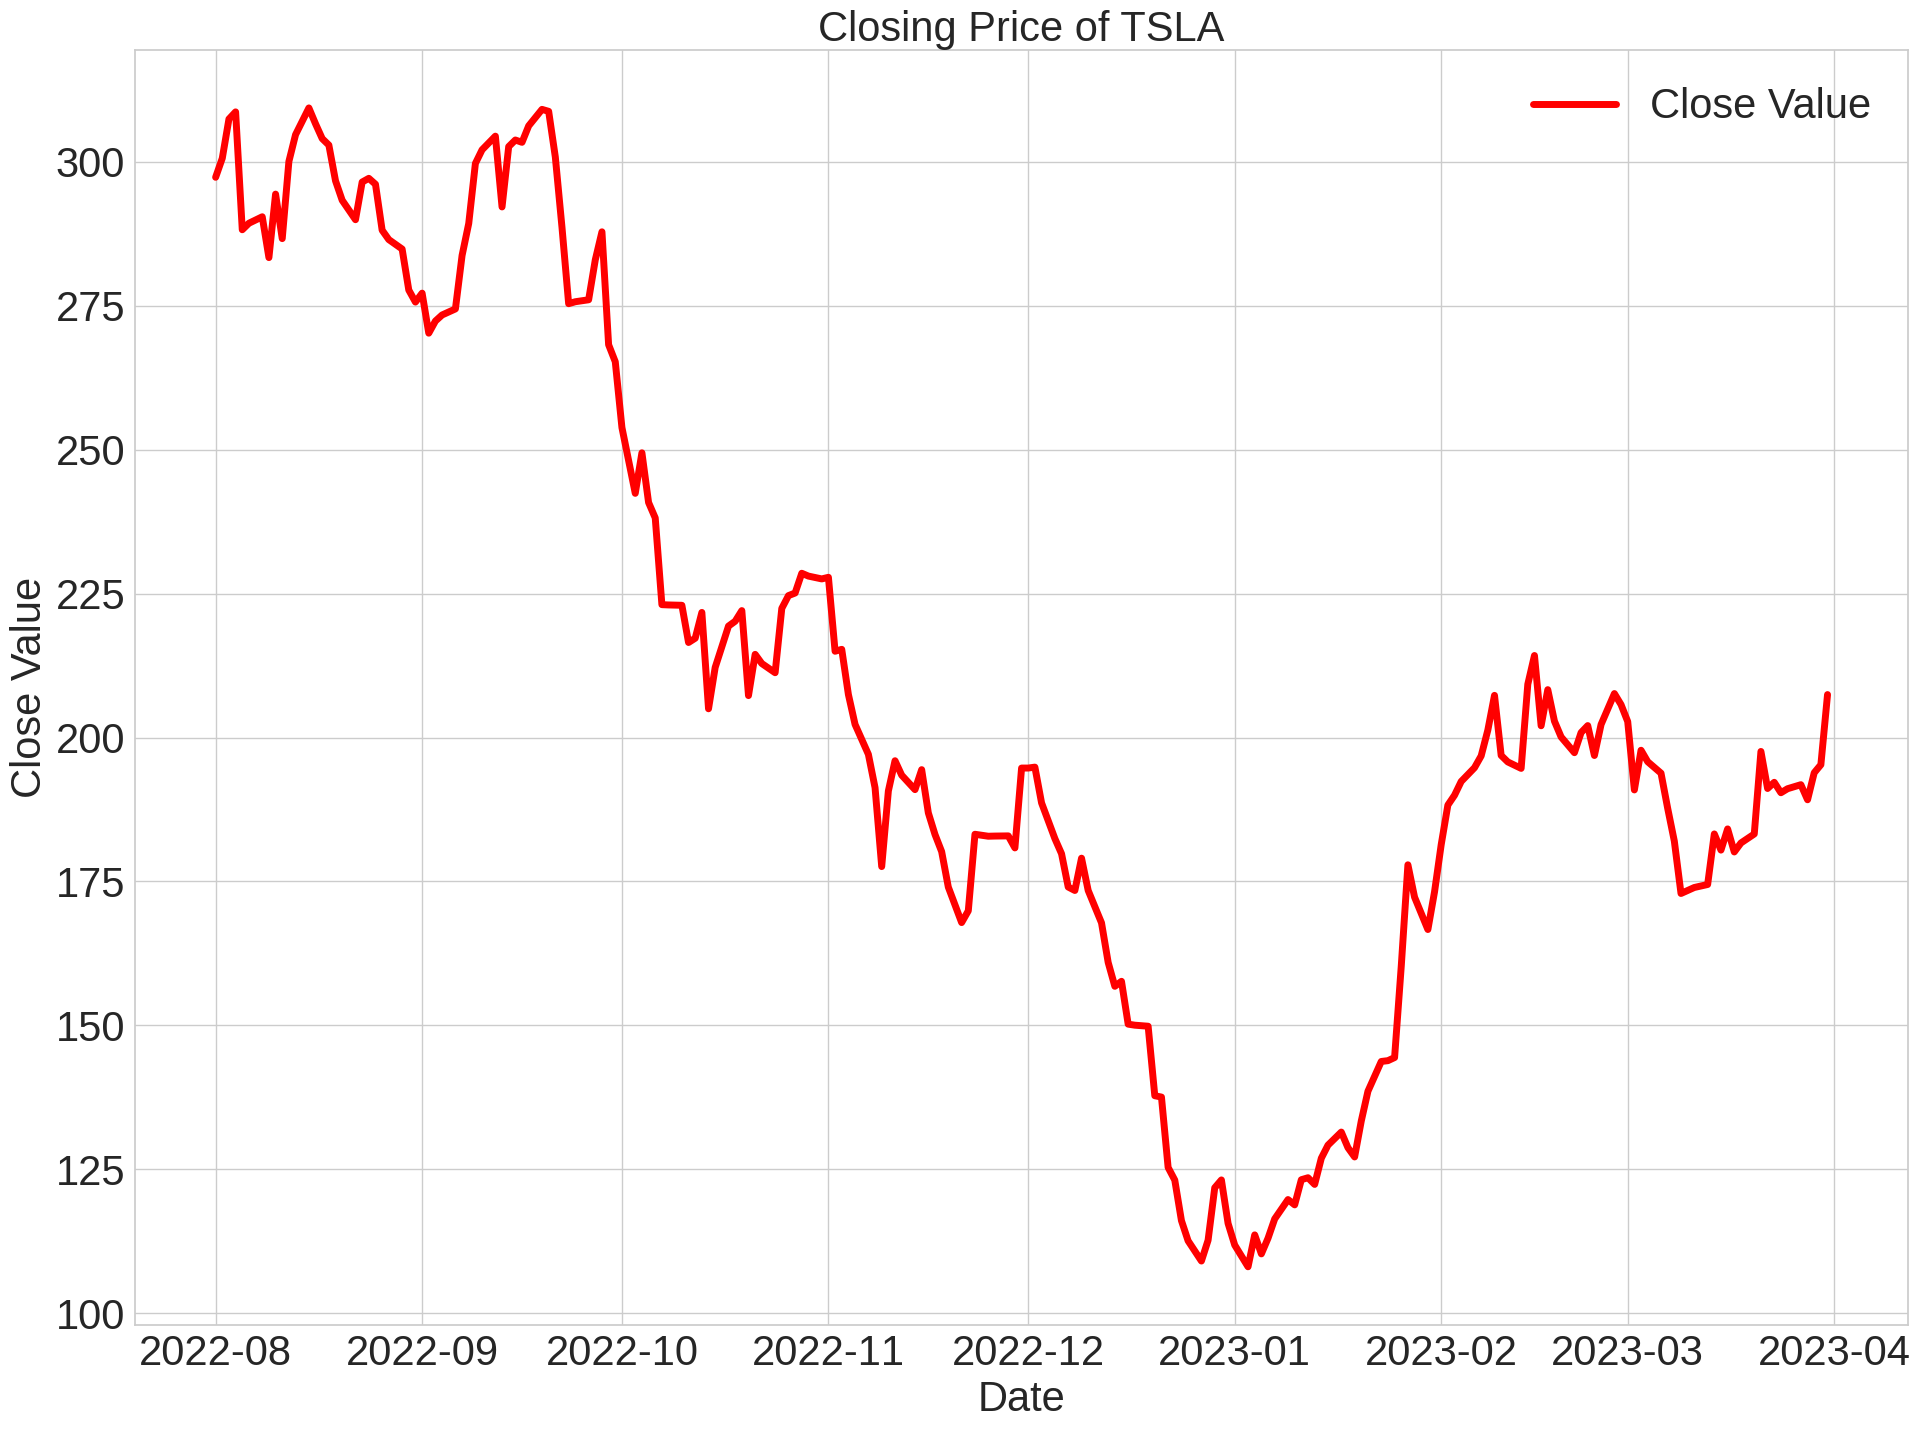

In [58]:
company_list = ['TSLA']
colors = ['red']

for i, company in enumerate(company_list, 1):
    plt.figure(figsize=(20, 15))
    dates = merged_dfs[company]['date']
    close_vals = merged_dfs[company]['close']
    plt.plot(dates, close_vals, label='Close Value', linewidth=5, color=colors[i-1])
    
    plt.ylabel('Close Value')
    plt.xlabel('Date')
    plt.legend(loc='best')
    plt.title(f"Closing Price of {company_list[i - 1]}")
    
    plt.tight_layout()   
    plt.show()

In [59]:
def plot_corr_heatmaps(categories, tickers, norm_dfs):
    cmaps = ['YlOrBr', 'YlOrRd', 'YlGnBu', 'PuBuGn', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu']
    for category in categories:
        ticker=tickers[category]
        plt.figure(figsize=(10,6))
        sns.heatmap(norm_dfs[ticker].corr('spearman'),cmap='RdYlGn',annot=True, linewidths=0.2)
        plt.title(f'Correlation Heatmap For {ticker}', fontsize=14)
        # if save == True and ticker in ['TSLA', 'XOM', 'AAPL', 'MRNA']:
        #     plt.savefig(f'images/correlation-heatmap-{ticker}', transparent=True, dpi=400)
        plt.show()

In [60]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE) 

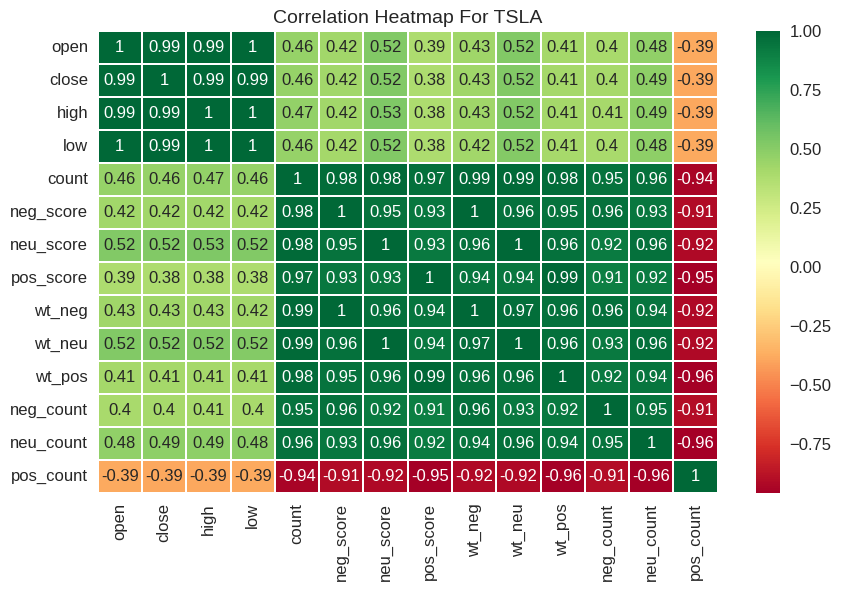

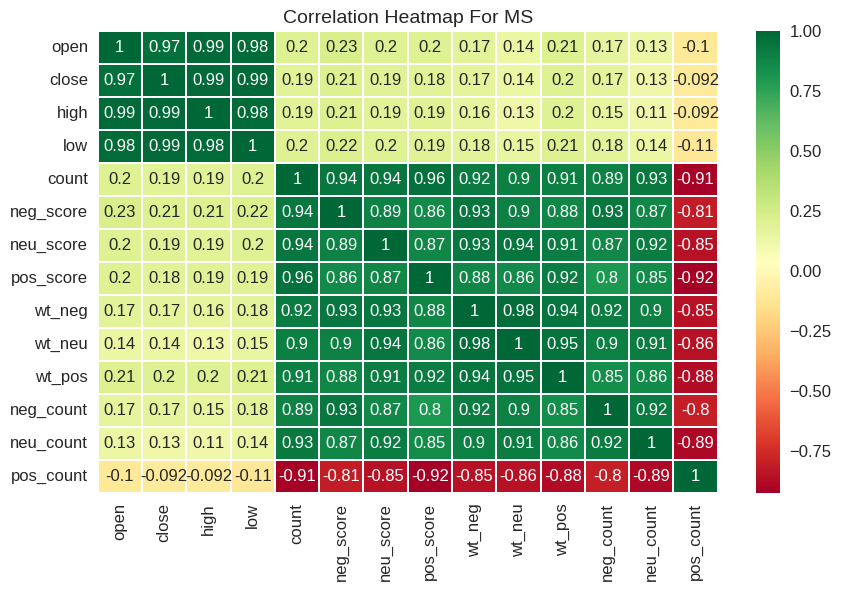

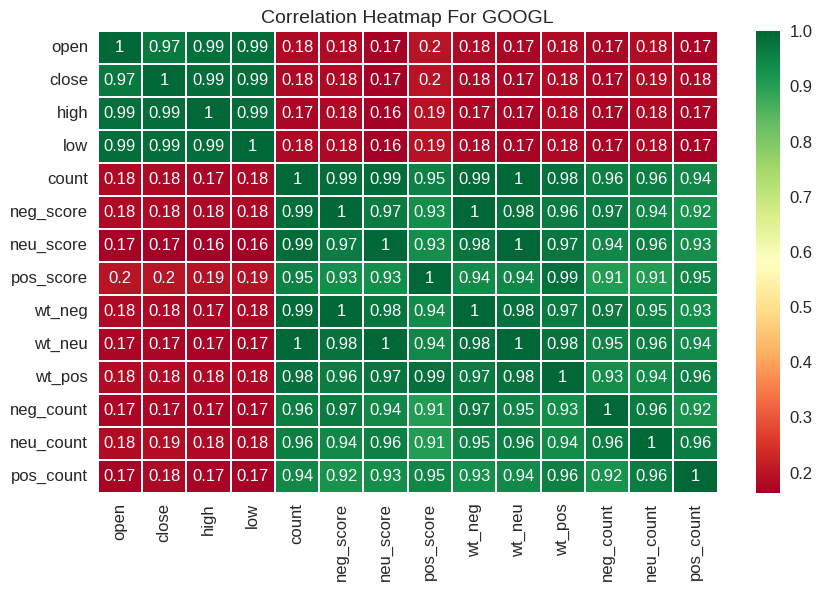

In [61]:
plot_corr_heatmaps(categories, tickers, norm_dfs)

In [62]:
def RMSE(y_true, y_pred):
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    
    return round(RMSE, 6)

In [63]:
def print_metrics(model, X_train, X_test, y_test):
    
    n_points = X_train.shape[0] #number of datapoints
    n_features = X_train.shape[1] #number of features

    #predict probabilities for test set
    y_hat = model.predict(X_test)

    rmse_val = RMSE(y_test.reshape(-1,1), y_hat)
    print('RMSE:\t\t\t%f' % rmse_val)
    
    mse_val = mse(y_test.reshape(-1, 1), y_hat)
    print('MSE:\t\t\t%f' % mse_val)
    
    mae_val = mae(y_test.reshape(-1, 1), y_hat)
    print('MAE:\t\t\t%f' % mae_val)

    r2 = r2_score(y_test.reshape(-1,1), y_hat)
    print('R2 Score:\t\t%f' % r2)

    adj_r2 = 1-(1-r2)*(n_points-1)/(n_points-n_features-1)
    print('Adj. R2 Score:\t\t%f' % adj_r2)
    
    exp_var_score = explained_variance_score(y_test.reshape(-1,1), y_hat)
    print('Exp. Variance Score:\t%f' % exp_var_score)

    max_err = max_error(y_test.reshape(-1,1), y_hat)
    print('Max Error:\t\t%f' % max_err)

In [64]:
def plot_prediction_graph(model, X_train, X_test, y_test, output_labels_unscaled, dates, ticker):
    predicted  = model.predict(X_test)
    test_label = y_test.reshape(-1,1)
    predicted = np.array(predicted).reshape(-1,1)
    print("Predicted","\t","Value")
    for i in range(len(predicted)):
      print(predicted[i],"\t",test_label[i])
    len_t = len(X_train)

    for j in range(len_t , len_t + len(X_test)):
        temp = output_labels_unscaled[j]
        test_label[j - len_t] = test_label[j - len_t] * temp + temp
        predicted[j - len_t] = predicted[j - len_t] * temp + temp

    plt.figure(figsize=(15, 10))
    plt.plot(dates, predicted, color = 'green', label = 'Predicted Close', linewidth=2)
    plt.plot(dates, test_label, color = 'red', label = 'Actual Close', linewidth=2)
    plt.title('Stock - Closing Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y')) 
    plt.legend(loc='best')
    
    # if ticker in ['TSLA', 'XOM', 'MSFT', 'MRNA']:
    #     plt.savefig(f'images/catboost-prediction-graph-{ticker}', transparent=True, dpi=400)
    
    plt.show()

In [65]:
def print_feature_importance(model, df_cols, ticker):
    sorted_feature_importance = model.feature_importances_.argsort()

    plt.figure(figsize=(10, 5))
    plt.barh(df_cols[sorted_feature_importance], 
             model.feature_importances_[sorted_feature_importance], 
             color = 'turquoise')
    plt.title(f"CatBoost Feature Importance - {ticker}")
    plt.show()

In [66]:
def get_train_test_set(ticker, norm_df, output_label = 'close'):
    temp_df = norm_df.copy(deep = True)
    output_values = temp_df.loc[:, output_label]
    temp_df.drop(columns = ['close'], inplace = True)
    
    temp_df = temp_df.to_numpy()
    output_values = output_values.to_numpy()
    
    X_train, X_test, y_train, y_test = train_test_split(temp_df, output_values, \
                                                        test_size = 0.2, random_state = 3, shuffle=False)
    
    Xd_train, Xd_test, yd_train, yd_test = train_test_split(merged_dfs[ticker], merged_dfs[ticker]['close'], \
                                                        test_size = 0.2, random_state = 3, shuffle=False)

    
    test_dates = Xd_test['date'] #Collect Test data dates
    
    while len(test_dates) > len(y_test): #in case the array size is higher for dates
        test_dates = test_dates[:-1].copy()
    
    
    del Xd_train, Xd_test, yd_train, yd_test #Run GC
    del temp_df, output_values #Run GC
    
    return X_train, X_test, y_train, y_test, test_dates

In [67]:
def get_unscaled_output_labels(categories, tickers, dfs, output_label='close'):
    unscaled_op_labels = dict()
    
    for category in categories:
        ticker=tickers[category]
        unscaled_op_labels[ticker] = dfs[ticker].loc[:, output_label].copy(deep=True)

    return unscaled_op_labels

In [68]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels):
#     params = {'depth': 2,
#               'iterations': 200,
#               'learning_rate': 0.03,
#               'l2_leaf_reg': 3}

    params = {
            'eval_metric': 'MAE',
            'iterations': 200,
            'l2_leaf_reg': 10,
            'depth': 4,
            'learning_rate': 0.05,
            'loss_function': 'MAE'
        }


    model = CatBoostRegressor(**params, 
                                 logging_level='Silent', 
                                 random_state=3,
                                )
    
    for category in categories:
        ticker=tickers[category]
        print(f"======CURRENTLY WORKING ON {ticker}======")
        
        X_train, X_test, y_train, y_test, dates = get_train_test_set(ticker, norm_dfs[ticker], 
                                                                      output_label='close')
        
        model.fit(X_train, y_train)
        
        print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
        print_metrics(model, X_train, X_test, y_test)
        plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker], dates, ticker)
        
        
        print(f"======FINISHED WORKING ON {ticker}======")

In [69]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, merged_dfs, output_label='close')

======CURRENTLY WORKING ON TSLA======


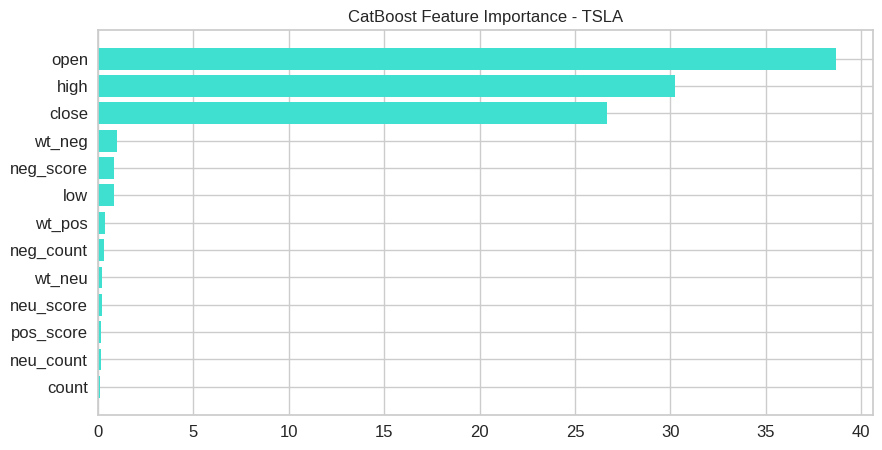

RMSE:			0.026907
MSE:			0.000724
MAE:			0.021380
R2 Score:		0.725640
Adj. R2 Score:		0.705825
Exp. Variance Score:	0.727788
Max Error:		0.077444
Predicted 	 Value
[0.40055369] 	 [0.43564257]
[0.3867475] 	 [0.43285955]
[0.4000432] 	 [0.43007652]
[0.42523921] 	 [0.50268362]
[0.52647742] 	 [0.52748237]
[0.52478573] 	 [0.46685216]
[0.48358437] 	 [0.4980121]
[0.47206312] 	 [0.47082794]
[0.48718569] 	 [0.457211]
[0.4803163] 	 [0.45040253]
[0.48728111] 	 [0.44364374]
[0.4249317] 	 [0.46098797]
[0.4776904] 	 [0.46700132]
[0.4577385] 	 [0.44120864]
[0.46808636] 	 [0.46794552]
[0.48788918] 	 [0.48131397]
[0.48588612] 	 [0.49463275]
[0.51959584] 	 [0.48509097]
[0.48035186] 	 [0.47048008]
[0.39079642] 	 [0.41148987]
[0.46693423] 	 [0.445731]
[0.4415465] 	 [0.43584136]
[0.45934996] 	 [0.43087167]
[0.4678474] 	 [0.42595168]
[0.39836265] 	 [0.39563664]
[0.38402342] 	 [0.36725971]
[0.36091852] 	 [0.32213496]
[0.31956416] 	 [0.32471922]
[0.30078718] 	 [0.32730344]
[0.29344219] 	 [0.32859556]
[0.2911118

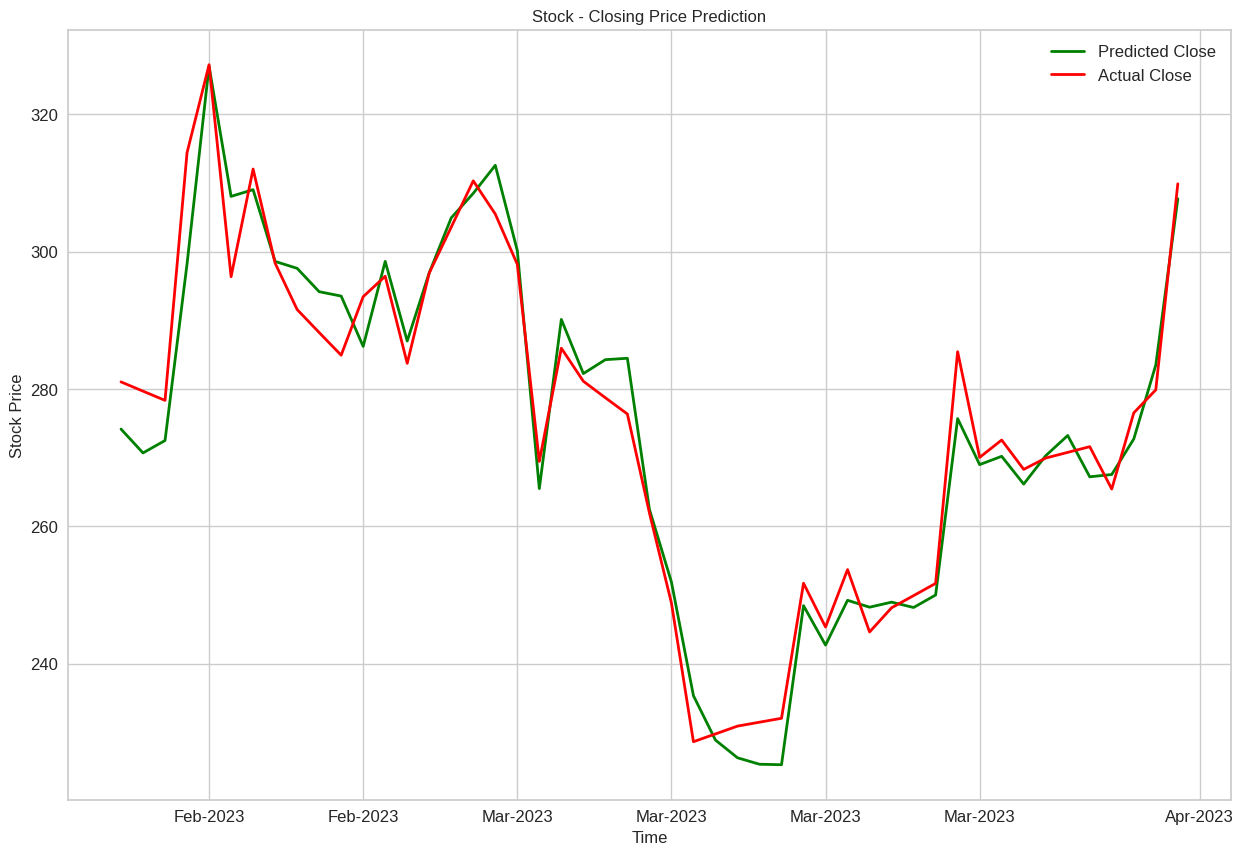

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


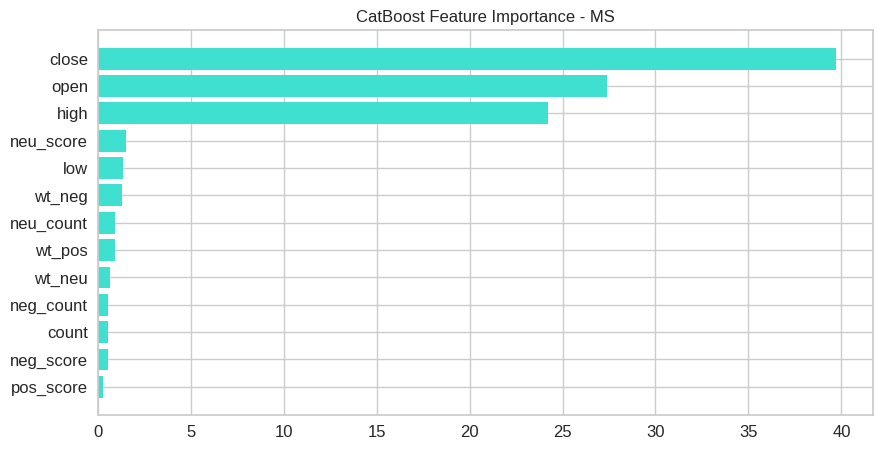

RMSE:			0.050987
MSE:			0.002600
MAE:			0.038837
R2 Score:		0.951423
Adj. R2 Score:		0.947915
Exp. Variance Score:	0.956554
Max Error:		0.152767
Predicted 	 Value
[0.8924149] 	 [0.92596937]
[0.90767421] 	 [0.93576177]
[0.90460807] 	 [0.94516247]
[0.89243309] 	 [0.98942405]
[0.9094586] 	 [1.]
[0.91407845] 	 [0.95064622]
[0.90516956] 	 [0.94829612]
[0.91724428] 	 [0.91147661]
[0.90532911] 	 [0.8930669]
[0.9345246] 	 [0.88366619]
[0.90428019] 	 [0.8742656]
[0.85914334] 	 [0.86055601]
[0.93041615] 	 [0.88679984]
[0.88480967] 	 [0.87739894]
[0.89931645] 	 [0.85781425]
[0.92034619] 	 [0.84802185]
[0.87566212] 	 [0.83822933]
[0.88065368] 	 [0.83039553]
[0.85838194] 	 [0.81825303]
[0.84293821] 	 [0.81394437]
[0.87892184] 	 [0.90207599]
[0.90406194] 	 [0.9028593]
[0.90892743] 	 [0.903251]
[0.90489662] 	 [0.90403427]
[0.88972707] 	 [0.81316082]
[0.85467641] 	 [0.80689384]
[0.81473326] 	 [0.66196611]
[0.70966141] 	 [0.57775169]
[0.59390638] 	 [0.53740688]
[0.5673362] 	 [0.51703868]
[0.52297682] 	

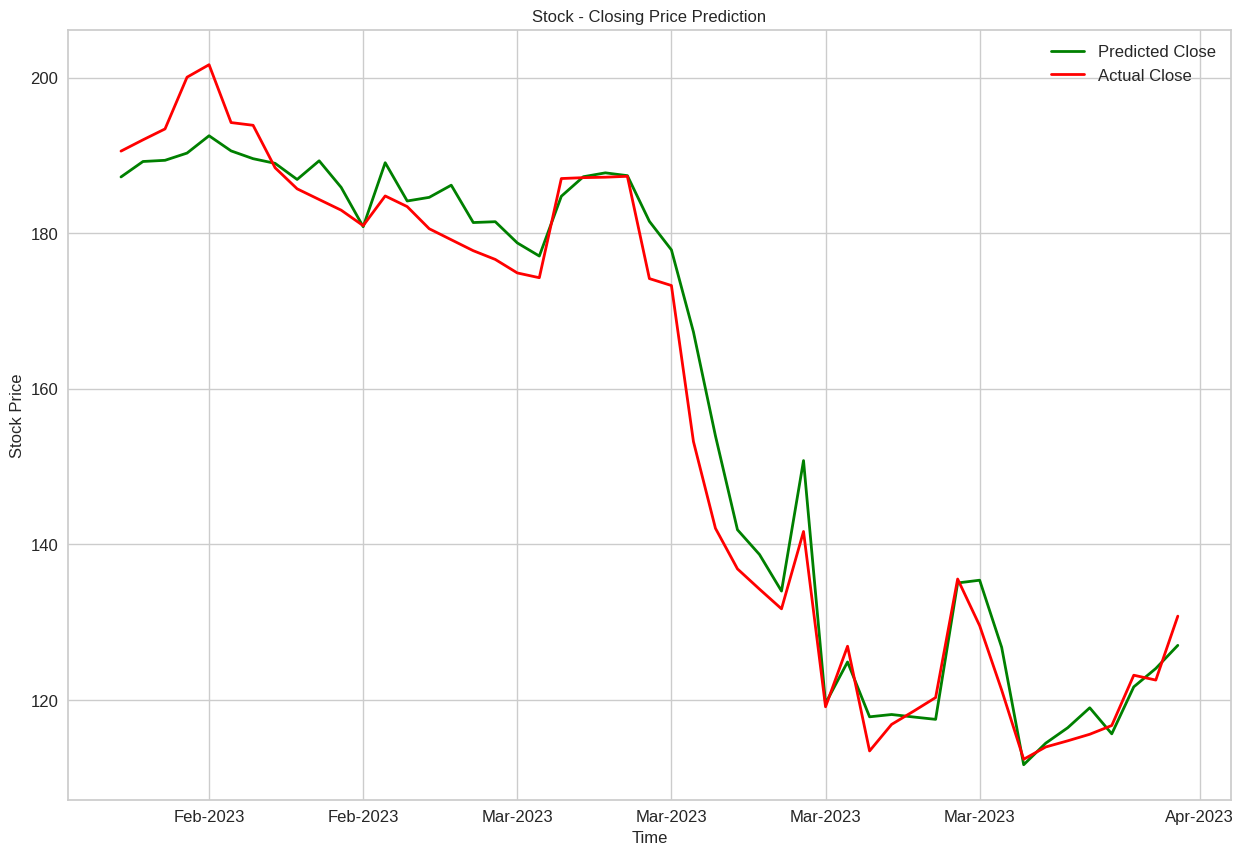

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


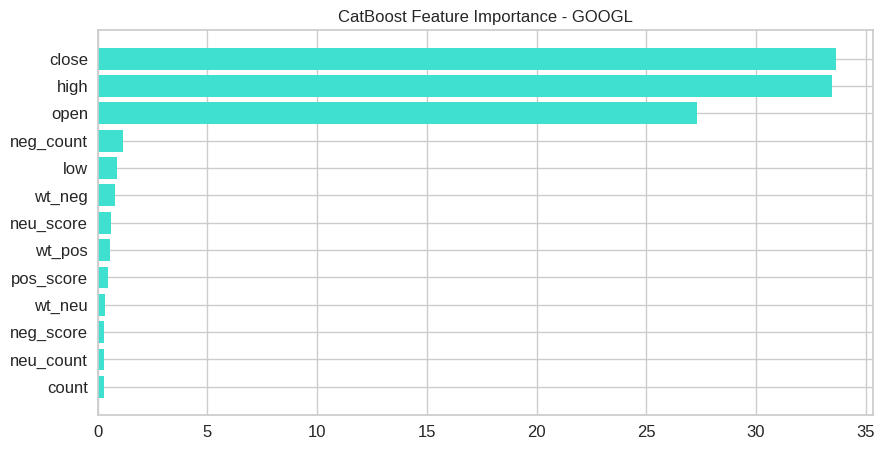

RMSE:			0.028563
MSE:			0.000816
MAE:			0.023584
R2 Score:		0.952055
Adj. R2 Score:		0.948592
Exp. Variance Score:	0.953192
Max Error:		0.061074
Predicted 	 Value
[0.29155525] 	 [0.28874513]
[0.26828856] 	 [0.28900387]
[0.27410092] 	 [0.28926262]
[0.25839954] 	 [0.29107372]
[0.3200785] 	 [0.34954725]
[0.34507972] 	 [0.31254855]
[0.26925487] 	 [0.28253551]
[0.25347855] 	 [0.24941784]
[0.25112395] 	 [0.23285898]
[0.24426008] 	 [0.22457955]
[0.24505193] 	 [0.21630014]
[0.20225094] 	 [0.21267792]
[0.17901826] 	 [0.19301419]
[0.15583255] 	 [0.14747728]
[0.15994841] 	 [0.15705044]
[0.15827593] 	 [0.16196636]
[0.16159545] 	 [0.16662361]
[0.17329311] 	 [0.1715394]
[0.15760798] 	 [0.17930144]
[0.18535906] 	 [0.22173349]
[0.24017722] 	 [0.26442436]
[0.25119565] 	 [0.28357049]
[0.26065581] 	 [0.29314358]
[0.26596923] 	 [0.30271659]
[0.27914451] 	 [0.26985771]
[0.26067235] 	 [0.27994824]
[0.2582806] 	 [0.23001292]
[0.21224288] 	 [0.18628711]
[0.19417932] 	 [0.19249676]
[0.18508986] 	 [0.19560154]


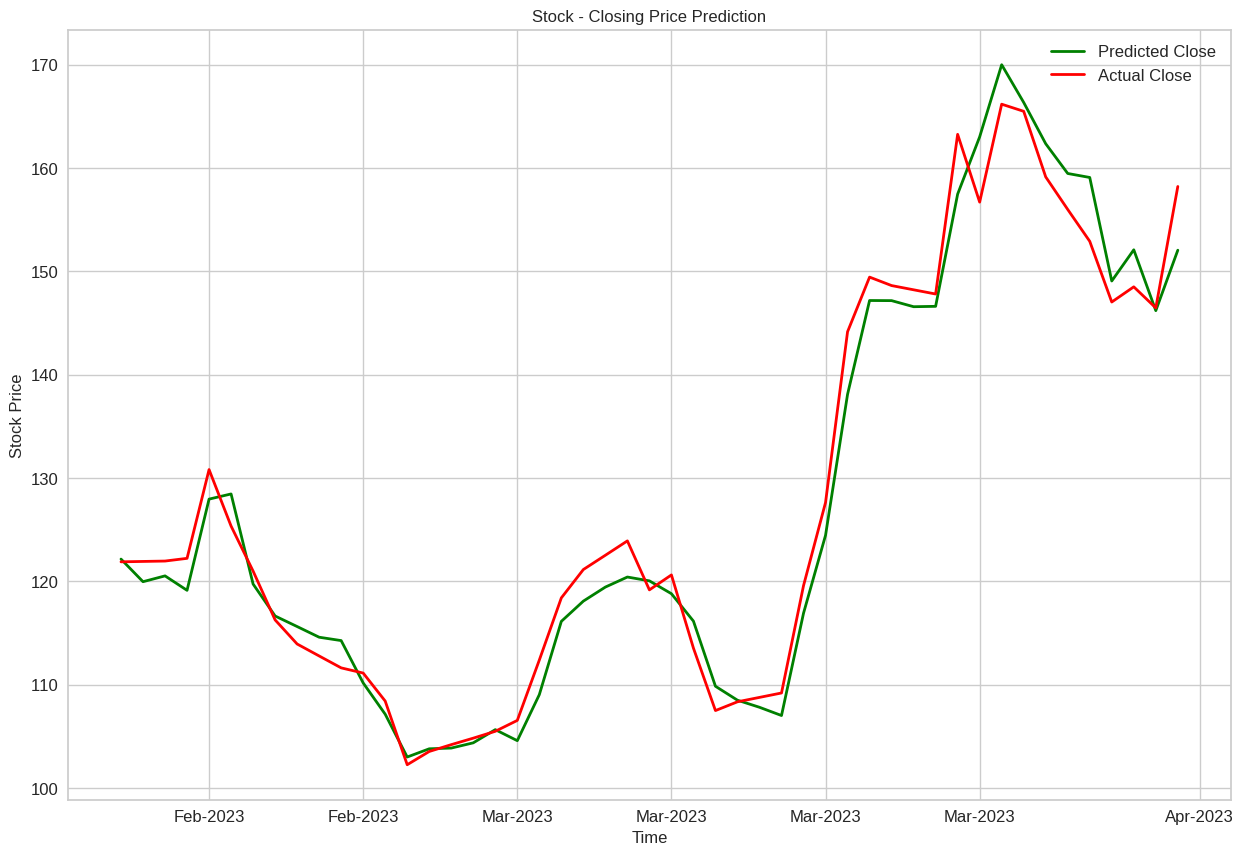

======FINISHED WORKING ON GOOGL======


In [70]:
train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels)

Using prev day open

In [71]:
def add_prev_day_value(categories, tickers, merged_dfs):
    prev_open_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
    
        t_df = merged_dfs[ticker].copy(deep = True)
        t_df = t_df.drop(columns = ['high', 'low', 'count', 'neg_score', 'neu_score', 'pos_score', \
                                    'neg_count', 'neu_count', 'pos_count'])

        t_minus1_df = t_df.copy(deep = True).drop(columns = ['close'])

        t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

        t_df = t_df.drop(columns=['open','wt_neg', 'wt_neu', 'wt_pos'])

        prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

        prev_open_df = prev_open_df[['date', 'open', 'wt_neg', 'wt_neu', 'wt_pos', 'close']]

        prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})
        
        #prev_open_df = prev_open_df.drop(columns = ['prev_open'])
        
        prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
        
        del prev_open_df #Perform GC

    return prev_open_dfs

In [72]:
prev_open_dfs = add_prev_day_value(categories, tickers, merged_dfs)

prev_open_dfs['TSLA']

,date,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,2022-08-02,301.276672,-16.876412,-26.904634,-41.171774,300.586670
1,2022-08-03,294.003326,-22.682993,-25.073643,-37.357318,307.396667
2,2022-08-04,305.000000,-2.331892,-6.009396,-13.196395,308.633331
3,2022-08-05,311.000000,-1.167563,-2.196746,-3.635691,288.170013
4,2022-08-06,302.670013,-16.216868,-16.855830,-160.879937,289.300000
...,...,...,...,...,...,...
237,2023-03-27,193.720000,-14.594635,-21.290344,-30.107518,191.809998
238,2023-03-28,194.419998,-232.793960,-281.636459,-465.958222,189.190002
239,2023-03-29,192.000000,-13.191043,-12.029059,-33.769606,193.880005
240,2023-03-30,193.130005,-50.816797,-73.301693,-115.862161,195.279999


In [73]:
prev_open_norm_dfs = normalize_datasets(categories, tickers, prev_open_dfs,True)

Data dimensions for TSLA: (242, 5) 

Data dimensions for MS: (242, 5) 

Data dimensions for GOOGL: (242, 5) 



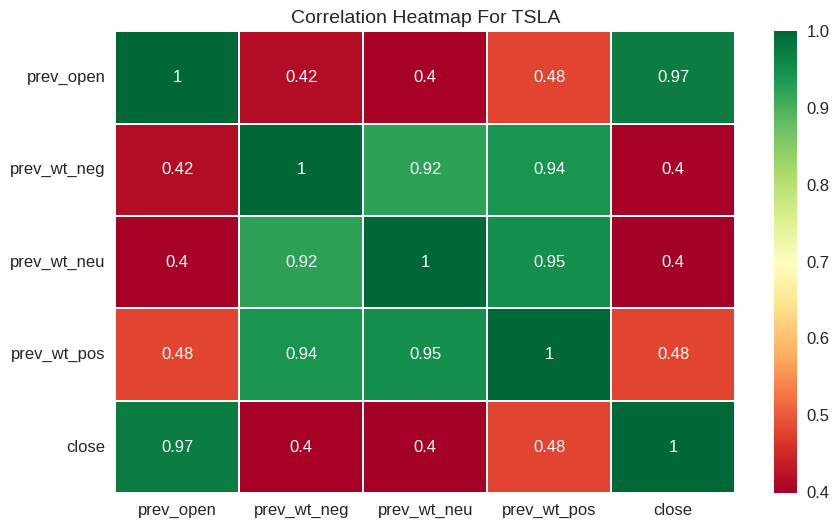

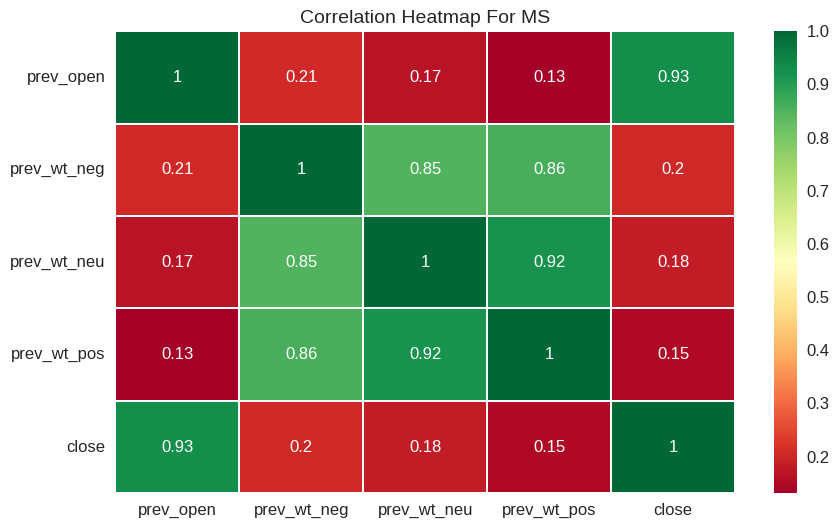

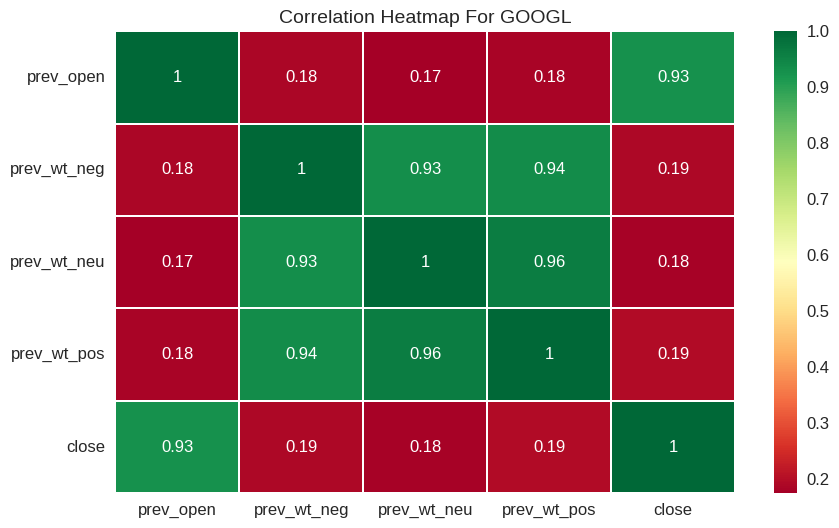

In [74]:
plot_corr_heatmaps(categories, tickers, prev_open_norm_dfs)

In [75]:
def train_and_test_model(categories, tickers, norm_dfs, unscaled_op_labels):
#     params = {'depth': 2,
#               'iterations': 200,
#               'learning_rate': 0.03,
#               'l2_leaf_reg': 3}

    params = {
            'eval_metric': 'MAE',
            'iterations': 200,
            'l2_leaf_reg': 10,
            'depth': 4,
            'learning_rate': 0.05,
            'loss_function': 'MAE'
        }


    model = CatBoostRegressor(**params, 
                                 logging_level='Silent', 
                                 random_state=3,
                                )
    
    for category in categories:
        ticker=tickers[category]
        print(f"======CURRENTLY WORKING ON {ticker}======")
        
        X_train, X_test, y_train, y_test, dates = get_train_test_set(ticker, norm_dfs[ticker], 
                                                                      output_label='close')
        
        model.fit(X_train, y_train)
        
        print_feature_importance(model, norm_dfs[ticker].columns.values, ticker)
        print_metrics(model, X_train, X_test, y_test)
        plot_prediction_graph(model, X_train, X_test, y_test, unscaled_op_labels[ticker], dates, ticker)
        
        
        print(f"======FINISHED WORKING ON {ticker}======")

======CURRENTLY WORKING ON TSLA======


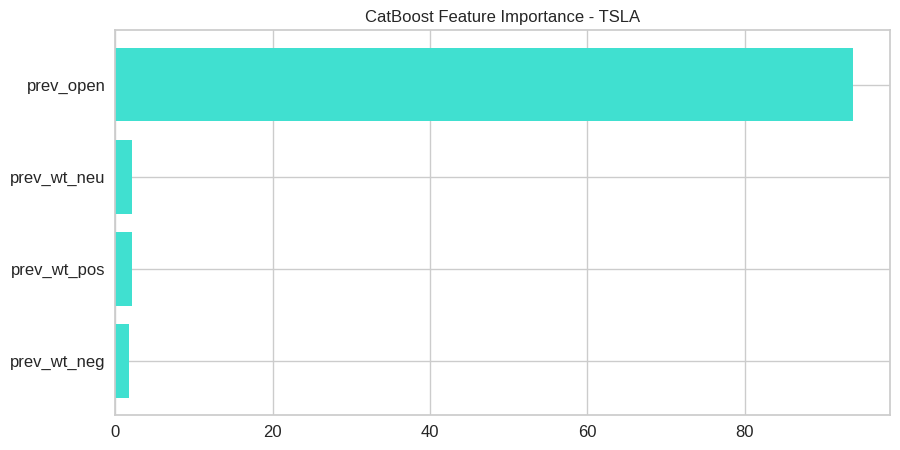

RMSE:			0.041235
MSE:			0.001700
MAE:			0.030837
R2 Score:		0.355642
Adj. R2 Score:		0.341932
Exp. Variance Score:	0.357471
Max Error:		0.117700
Predicted 	 Value
[0.47816853] 	 [0.43564257]
[0.4700573] 	 [0.43285955]
[0.40730338] 	 [0.43007652]
[0.4501037] 	 [0.50268362]
[0.43035625] 	 [0.52748237]
[0.54526189] 	 [0.46685216]
[0.52857267] 	 [0.4980121]
[0.48056824] 	 [0.47082794]
[0.465048] 	 [0.457211]
[0.4801414] 	 [0.45040253]
[0.4618497] 	 [0.44364374]
[0.48298396] 	 [0.46098797]
[0.47689637] 	 [0.46700132]
[0.44227005] 	 [0.44120864]
[0.4473812] 	 [0.46794552]
[0.47022527] 	 [0.48131397]
[0.48179233] 	 [0.49463275]
[0.47762088] 	 [0.48509097]
[0.53187917] 	 [0.47048008]
[0.47649191] 	 [0.41148987]
[0.39050234] 	 [0.445731]
[0.44081872] 	 [0.43584136]
[0.41034708] 	 [0.43087167]
[0.44615208] 	 [0.42595168]
[0.48040149] 	 [0.39563664]
[0.41301819] 	 [0.36725971]
[0.39420181] 	 [0.32213496]
[0.35481838] 	 [0.32471922]
[0.32494197] 	 [0.32730344]
[0.31966979] 	 [0.32859556]
[0.316745

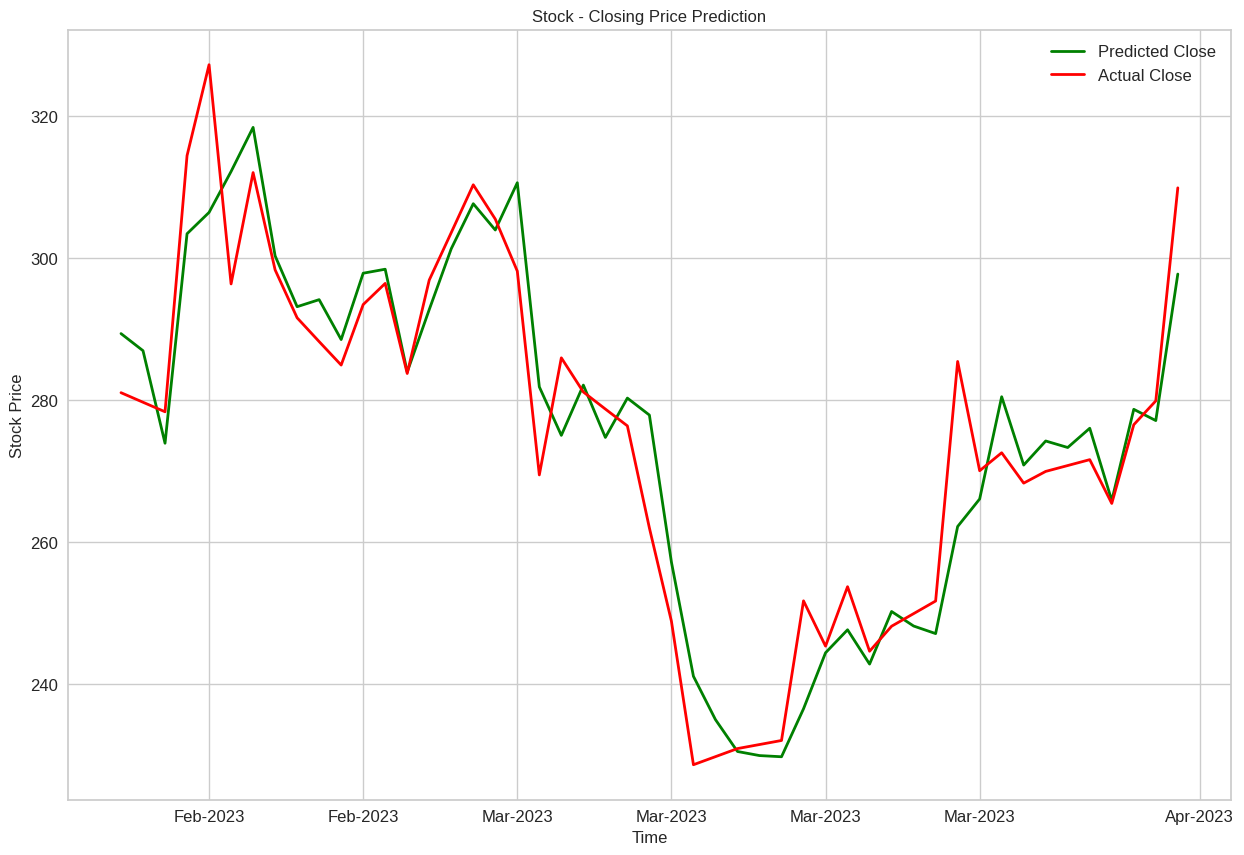

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


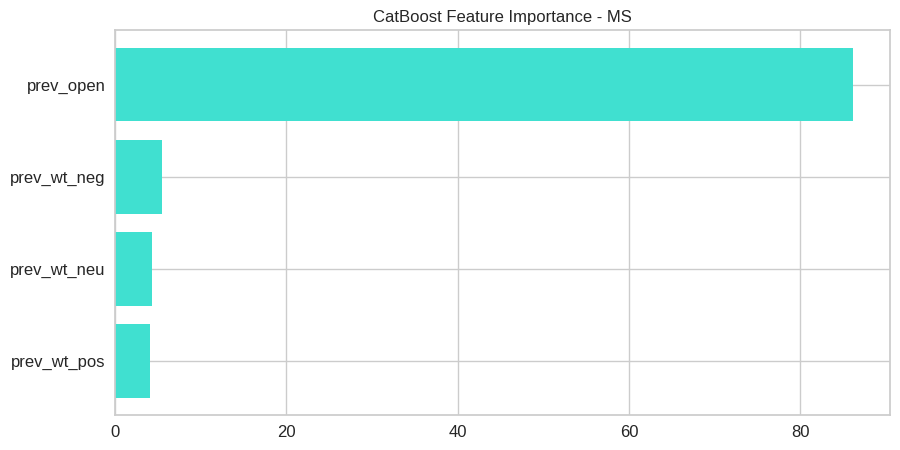

RMSE:			0.092240
MSE:			0.008508
MAE:			0.066091
R2 Score:		0.841020
Adj. R2 Score:		0.837637
Exp. Variance Score:	0.857690
Max Error:		0.282967
Predicted 	 Value
[0.87457213] 	 [0.92596937]
[0.88798608] 	 [0.93576177]
[0.89626244] 	 [0.94516247]
[0.91323975] 	 [0.98942405]
[0.88245029] 	 [1.]
[0.92494966] 	 [0.95064622]
[0.87597094] 	 [0.94829612]
[0.91772905] 	 [0.91147661]
[0.91500119] 	 [0.8930669]
[0.92459324] 	 [0.88366619]
[0.89336893] 	 [0.8742656]
[0.88096759] 	 [0.86055601]
[0.86264835] 	 [0.88679984]
[0.89365131] 	 [0.87739894]
[0.89455085] 	 [0.85781425]
[0.89670112] 	 [0.84802185]
[0.90820437] 	 [0.83822933]
[0.87016607] 	 [0.83039553]
[0.89568482] 	 [0.81825303]
[0.79009402] 	 [0.81394437]
[0.88143363] 	 [0.90207599]
[0.84548964] 	 [0.9028593]
[0.87077341] 	 [0.903251]
[0.92274583] 	 [0.90403427]
[0.91993082] 	 [0.81316082]
[0.91357521] 	 [0.80689384]
[0.8722726] 	 [0.66196611]
[0.86060477] 	 [0.57775169]
[0.67247195] 	 [0.53740688]
[0.61367976] 	 [0.51703868]
[0.58558887

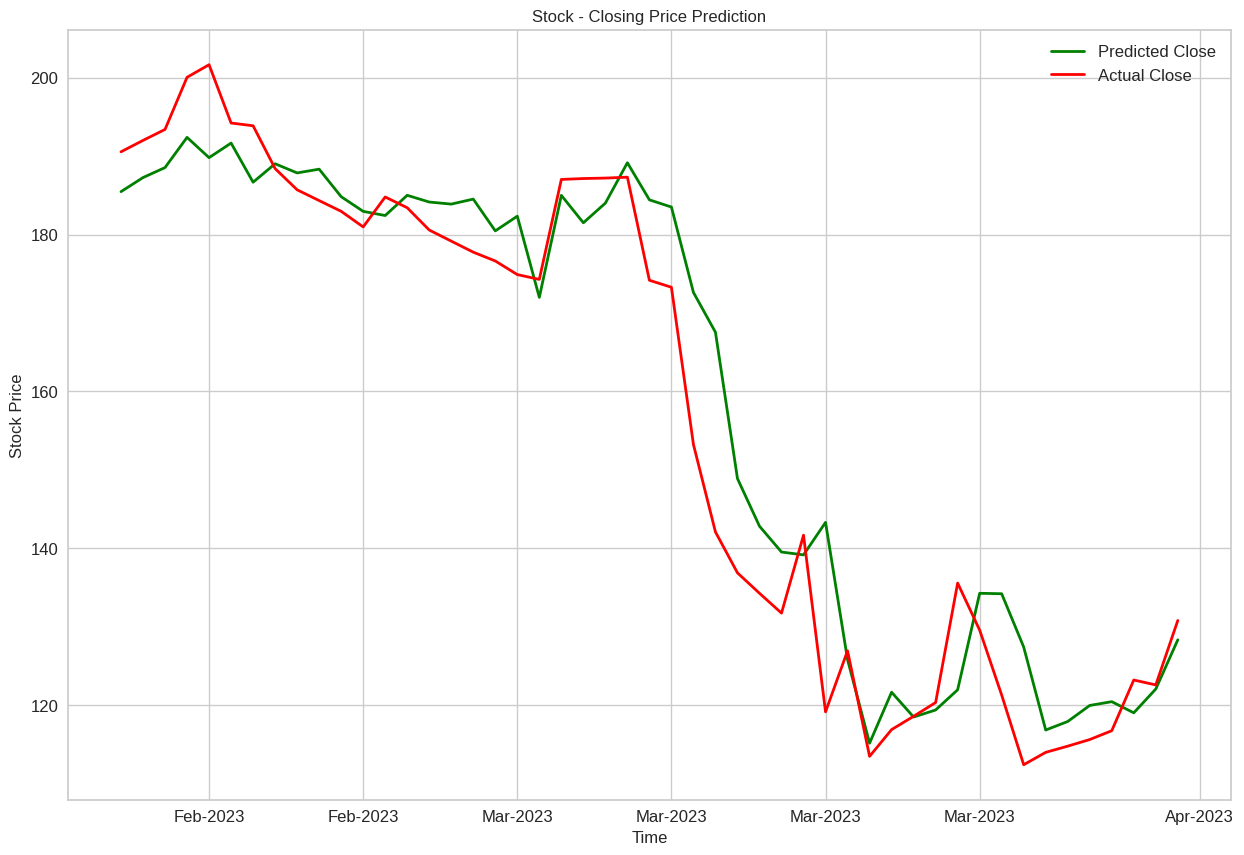

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


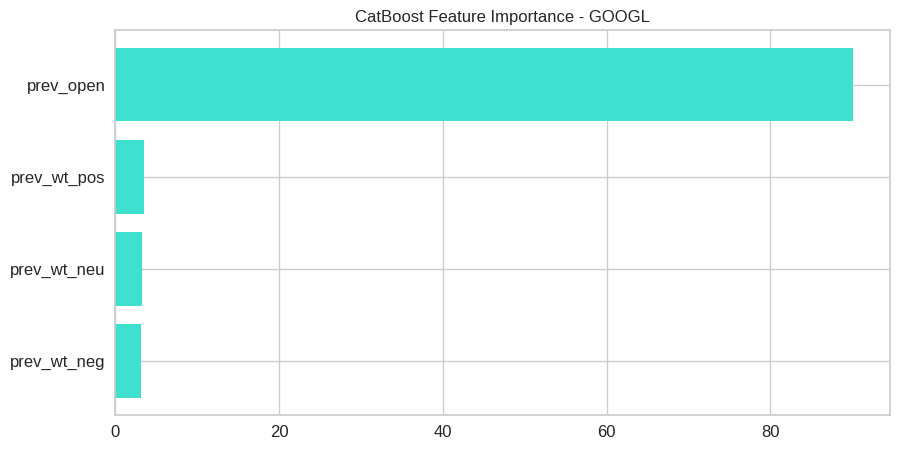

RMSE:			0.061213
MSE:			0.003747
MAE:			0.048643
R2 Score:		0.779796
Adj. R2 Score:		0.775111
Exp. Variance Score:	0.788996
Max Error:		0.177813
Predicted 	 Value
[0.36494131] 	 [0.28874513]
[0.32537109] 	 [0.28900387]
[0.32524958] 	 [0.28926262]
[0.2981586] 	 [0.29107372]
[0.28591163] 	 [0.34954725]
[0.28856273] 	 [0.31254855]
[0.34107297] 	 [0.28253551]
[0.31495739] 	 [0.24941784]
[0.27153072] 	 [0.23285898]
[0.24738605] 	 [0.22457955]
[0.25219276] 	 [0.21630014]
[0.24537535] 	 [0.21267792]
[0.21132648] 	 [0.19301419]
[0.2208289] 	 [0.14747728]
[0.14098219] 	 [0.15705044]
[0.1413809] 	 [0.16196636]
[0.13494876] 	 [0.16662361]
[0.15213362] 	 [0.1715394]
[0.13414054] 	 [0.17930144]
[0.12373368] 	 [0.22173349]
[0.15977173] 	 [0.26442436]
[0.24127239] 	 [0.28357049]
[0.24908076] 	 [0.29314358]
[0.27938189] 	 [0.30271659]
[0.26486985] 	 [0.26985771]
[0.32404198] 	 [0.27994824]
[0.27316405] 	 [0.23001292]
[0.29129224] 	 [0.18628711]
[0.21361645] 	 [0.19249676]
[0.19850212] 	 [0.19560154]
[

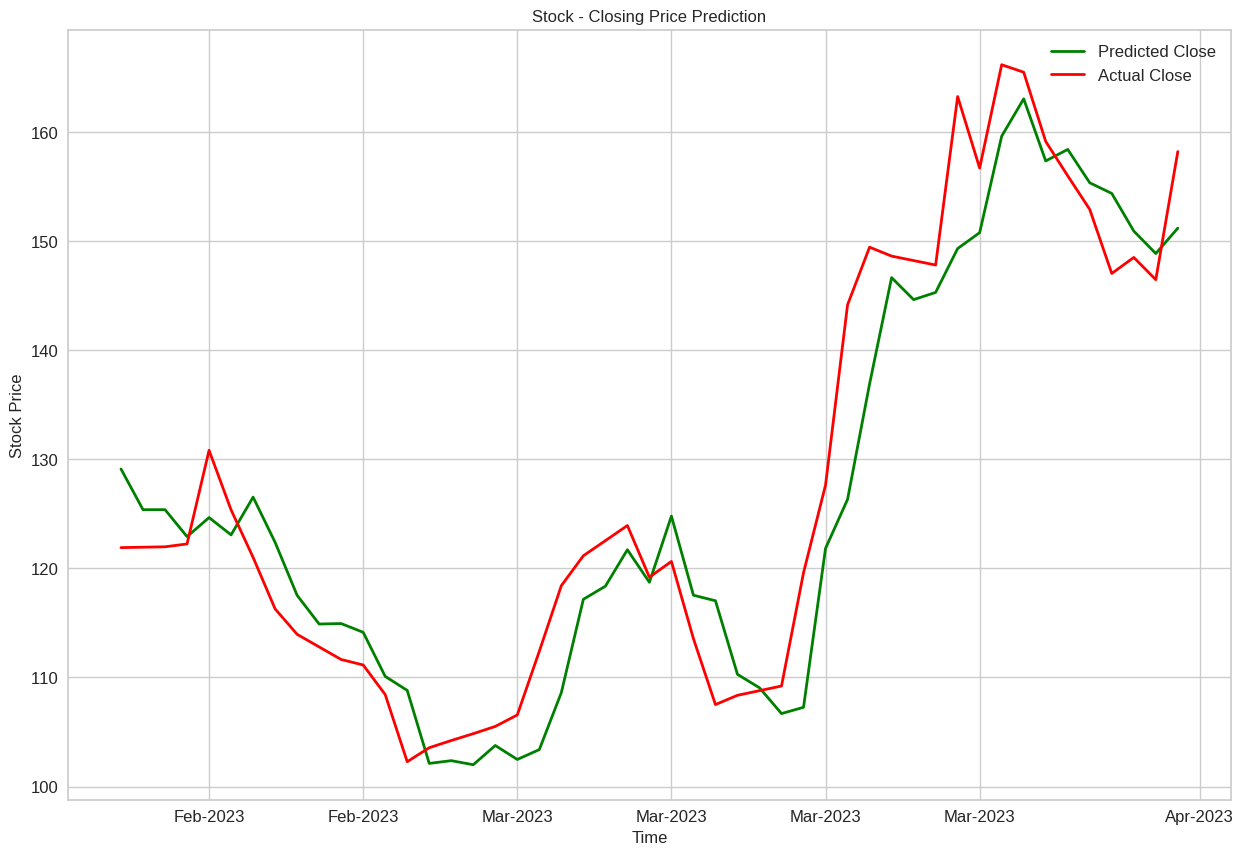

======FINISHED WORKING ON GOOGL======


In [76]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, prev_open_dfs, output_label='close')
train_and_test_model(categories, tickers, prev_open_norm_dfs, unscaled_op_labels)

Using both prev day and todays sentiment

In [77]:
def append_prev_day_value(categories, tickers, merged_dfs):
    prev_open_dfs = dict()
    
    for category in categories:
        ticker = tickers[category]
    
        t_df = merged_dfs[ticker].copy(deep = True)
        t_df = t_df.drop(columns = ['high', 'low', 'count', 'neg_score', 'neu_score', 'pos_score', \
                                    'neg_count', 'neu_count', 'pos_count'])

        t_minus1_df = t_df.copy(deep = True).drop(columns = ['close'])
        t_minus1_df = t_minus1_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})

        t_minus1_df['date'] = t_minus1_df['date'] + datetime.timedelta(1)

        #t_df = t_df.drop(columns=['open','wt_neg', 'wt_neu', 'wt_pos'])

        prev_open_df = pd.merge(t_df, t_minus1_df, on = ['date'])

        prev_open_df = prev_open_df[['date', 'open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open', 'prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']]

        #prev_open_df = prev_open_df.rename(columns = {'open': 'prev_open','wt_neg':'prev_wt_neg', 'wt_neu':'prev_wt_neu', 'wt_pos':'prev_wt_pos'})
        
        #prev_open_df = prev_open_df.drop(columns = ['prev_open'])
        
        prev_open_dfs[ticker] = prev_open_df.copy(deep=True)
        
        del prev_open_df #Perform GC

    return prev_open_dfs

In [78]:
both_open_dfs = append_prev_day_value(categories, tickers, merged_dfs)

both_open_dfs['TSLA']

,date,open,wt_neg,wt_neu,wt_pos,prev_open,prev_wt_neg,prev_wt_neu,prev_wt_pos,close
0,2022-08-02,294.003326,-22.682993,-25.073643,-37.357318,301.276672,-16.876412,-26.904634,-41.171774,300.586670
1,2022-08-03,305.000000,-2.331892,-6.009396,-13.196395,294.003326,-22.682993,-25.073643,-37.357318,307.396667
2,2022-08-04,311.000000,-1.167563,-2.196746,-3.635691,305.000000,-2.331892,-6.009396,-13.196395,308.633331
3,2022-08-05,302.670013,-16.216868,-16.855830,-160.879937,311.000000,-1.167563,-2.196746,-3.635691,288.170013
4,2022-08-06,298.840000,-5.747857,-10.603171,-13.781130,302.670013,-16.216868,-16.855830,-160.879937,289.300000
...,...,...,...,...,...,...,...,...,...,...
237,2023-03-27,194.419998,-232.793960,-281.636459,-465.958222,193.720000,-14.594635,-21.290344,-30.107518,191.809998
238,2023-03-28,192.000000,-13.191043,-12.029059,-33.769606,194.419998,-232.793960,-281.636459,-465.958222,189.190002
239,2023-03-29,193.130005,-50.816797,-73.301693,-115.862161,192.000000,-13.191043,-12.029059,-33.769606,193.880005
240,2023-03-30,195.580002,-150.363192,-88.522910,-161.982104,193.130005,-50.816797,-73.301693,-115.862161,195.279999


In [79]:
def normalize_datasets(categories, tickers, merged_dfs, reduced=False):
    norm_dfs = dict()
    
    scaler = MinMaxScaler()
    
    for category in categories:
        
        ticker = tickers[category]
        temp_norm_df = merged_dfs[ticker].copy(deep=True)
        
        temp_norm_df = temp_norm_df.drop(columns=['date'])

        temp_norm_df = scaler.fit_transform(temp_norm_df)

        if(reduced == False):

          temp_norm_df = pd.DataFrame(temp_norm_df, columns = [ 'open', 'close', 'high', 'low', \
                                                                'count','neg_score','neu_score', 'pos_score', \
                                                                'wt_neg', 'wt_neu', 'wt_pos', \
                                                                'neg_count', 'neu_count', 'pos_count'])
        else:
          columns = ['open', 'wt_neg', 'wt_neu', 'wt_pos','prev_open','prev_wt_neg', 'prev_wt_neu', 'prev_wt_pos', 'close']
          temp_norm_df = pd.DataFrame(temp_norm_df, columns = columns)
        
        
        norm_dfs[ticker] = temp_norm_df.copy(deep=True)
        
        print(f"Data dimensions for {ticker}:", temp_norm_df.shape, "\n")
        
        del temp_norm_df
            
    return norm_dfs

In [80]:
both_open_norm_dfs = normalize_datasets(categories, tickers, both_open_dfs,True)

Data dimensions for TSLA: (242, 9) 

Data dimensions for MS: (242, 9) 

Data dimensions for GOOGL: (242, 9) 



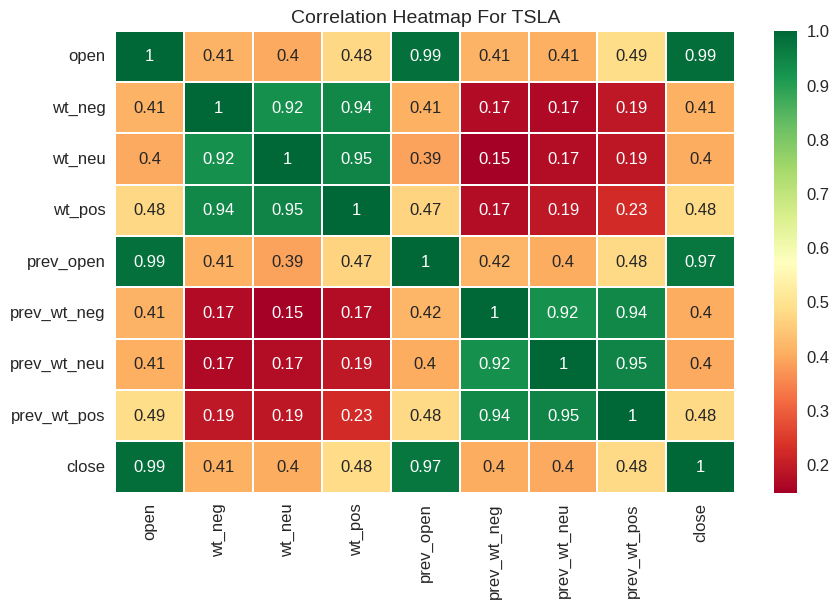

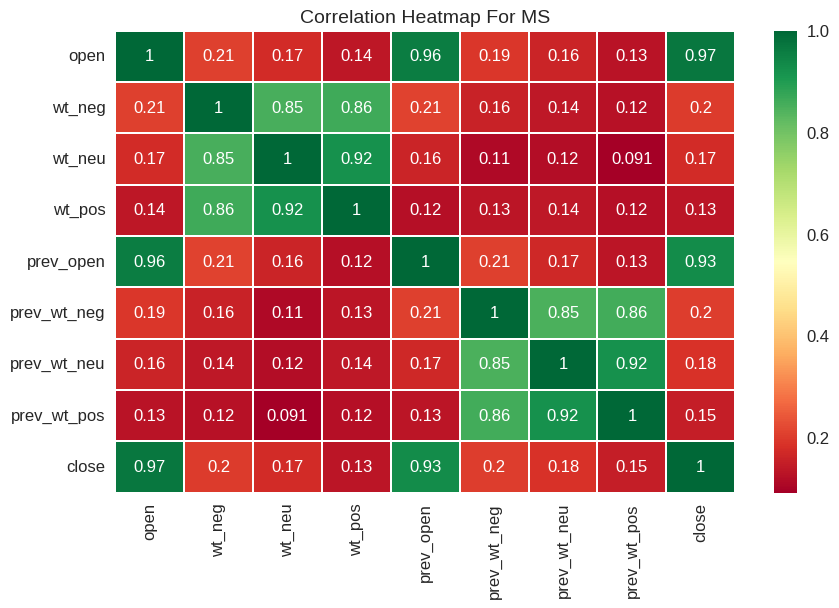

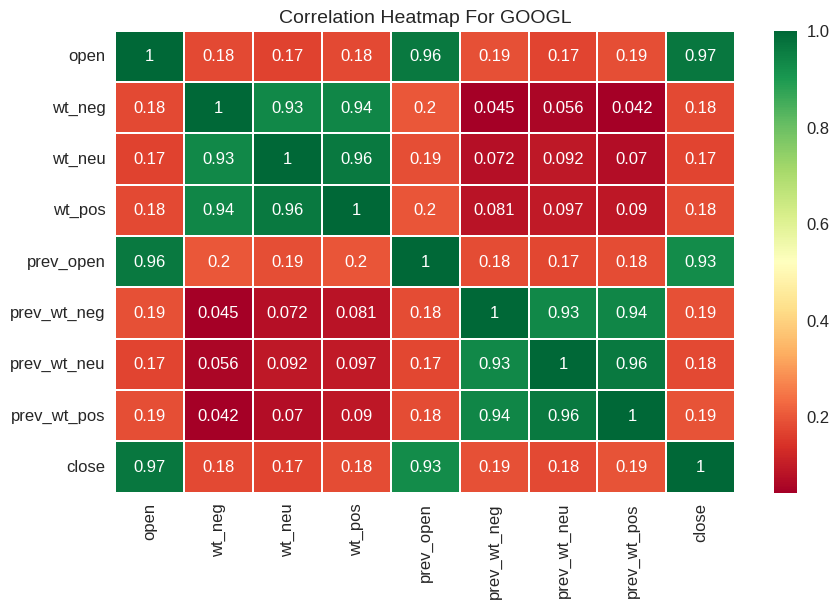

In [81]:
plot_corr_heatmaps(categories, tickers, both_open_norm_dfs)

======CURRENTLY WORKING ON TSLA======


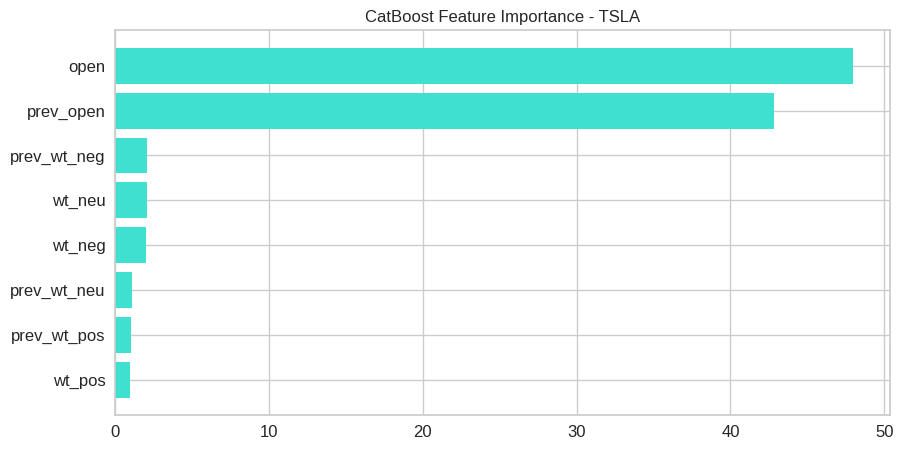

RMSE:			0.028960
MSE:			0.000839
MAE:			0.022558
R2 Score:		0.682165
Adj. R2 Score:		0.668347
Exp. Variance Score:	0.682169
Max Error:		0.078478
Predicted 	 Value
[0.45261399] 	 [0.43564257]
[0.45954984] 	 [0.43285955]
[0.44056277] 	 [0.43007652]
[0.42420525] 	 [0.50268362]
[0.47727683] 	 [0.52748237]
[0.4986924] 	 [0.46685216]
[0.47694913] 	 [0.4980121]
[0.47830923] 	 [0.47082794]
[0.4877058] 	 [0.457211]
[0.49089638] 	 [0.45040253]
[0.49286106] 	 [0.44364374]
[0.47517038] 	 [0.46098797]
[0.47986626] 	 [0.46700132]
[0.45309349] 	 [0.44120864]
[0.46816839] 	 [0.46794552]
[0.48694354] 	 [0.48131397]
[0.48320192] 	 [0.49463275]
[0.47002787] 	 [0.48509097]
[0.49781869] 	 [0.47048008]
[0.40276737] 	 [0.41148987]
[0.43052222] 	 [0.445731]
[0.41971346] 	 [0.43584136]
[0.45696109] 	 [0.43087167]
[0.46689578] 	 [0.42595168]
[0.41435933] 	 [0.39563664]
[0.39058892] 	 [0.36725971]
[0.37457004] 	 [0.32213496]
[0.33205503] 	 [0.32471922]
[0.3228705] 	 [0.32730344]
[0.29737577] 	 [0.32859556]
[0.31

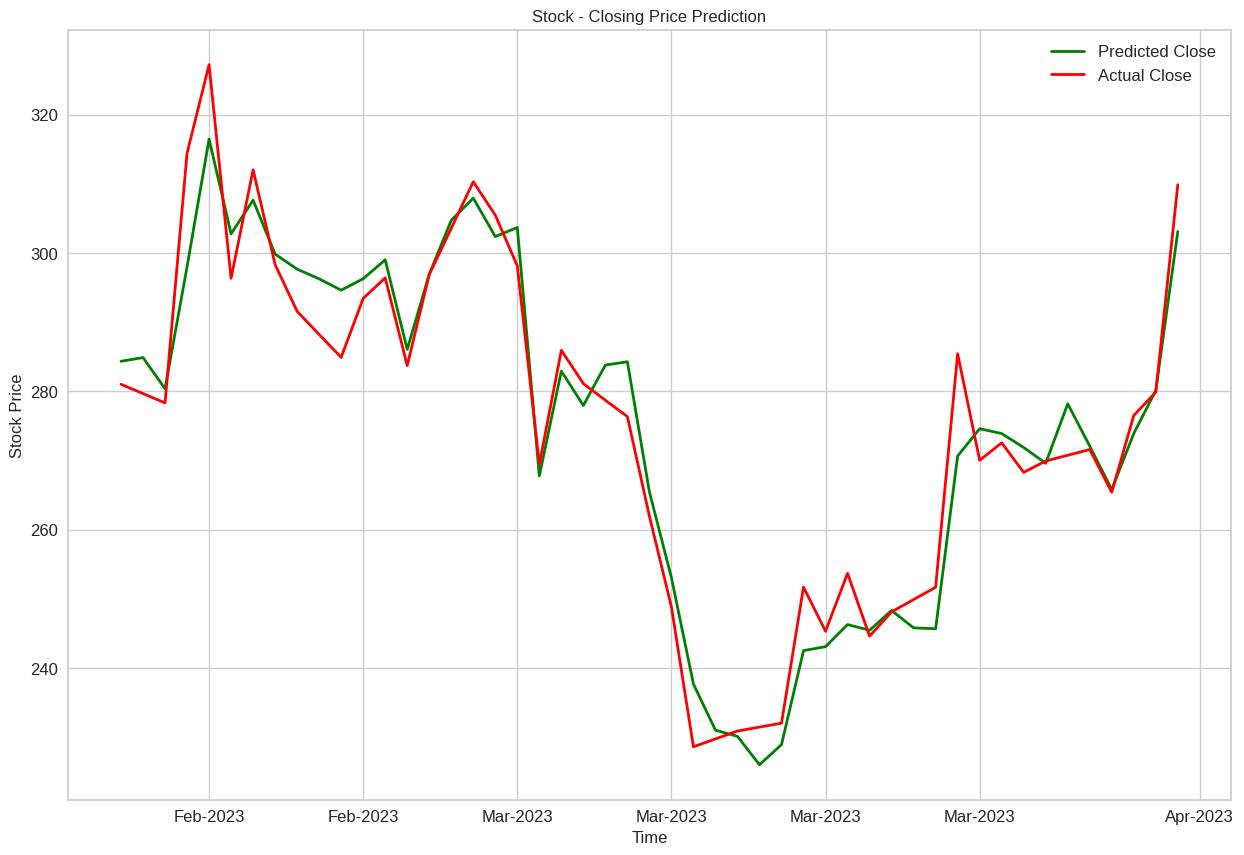

======FINISHED WORKING ON TSLA======
======CURRENTLY WORKING ON MS======


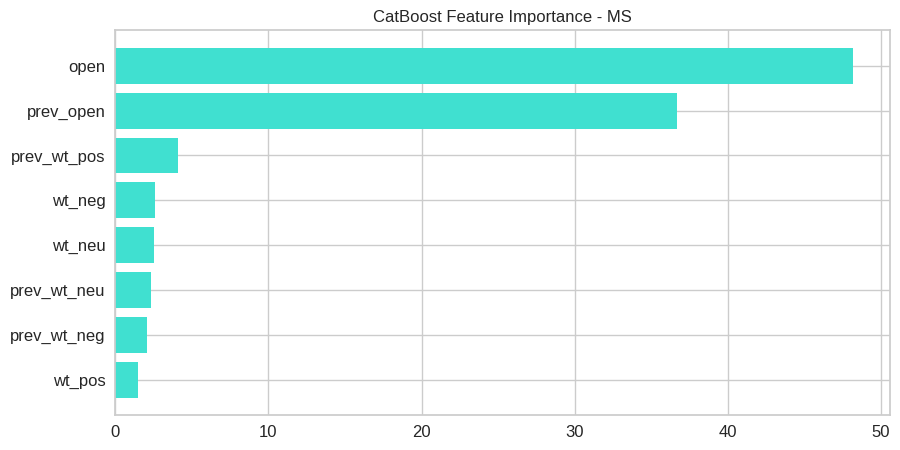

RMSE:			0.066497
MSE:			0.004422
MAE:			0.051237
R2 Score:		0.917377
Adj. R2 Score:		0.913784
Exp. Variance Score:	0.932837
Max Error:		0.198103
Predicted 	 Value
[0.916126] 	 [0.92596937]
[0.92104987] 	 [0.93576177]
[0.91894888] 	 [0.94516247]
[0.91463488] 	 [0.98942405]
[0.88997535] 	 [1.]
[0.89911904] 	 [0.95064622]
[0.90499584] 	 [0.94829612]
[0.91720898] 	 [0.91147661]
[0.91863034] 	 [0.8930669]
[0.90841804] 	 [0.88366619]
[0.91484988] 	 [0.8742656]
[0.88877426] 	 [0.86055601]
[0.89178515] 	 [0.88679984]
[0.90309132] 	 [0.87739894]
[0.90411831] 	 [0.85781425]
[0.92092873] 	 [0.84802185]
[0.90539636] 	 [0.83822933]
[0.89245469] 	 [0.83039553]
[0.82238962] 	 [0.81825303]
[0.80471135] 	 [0.81394437]
[0.89404433] 	 [0.90207599]
[0.8833031] 	 [0.9028593]
[0.91321549] 	 [0.903251]
[0.9206457] 	 [0.90403427]
[0.91570845] 	 [0.81316082]
[0.88412974] 	 [0.80689384]
[0.8600688] 	 [0.66196611]
[0.75976202] 	 [0.57775169]
[0.63601583] 	 [0.53740688]
[0.58029113] 	 [0.51703868]
[0.54310905] 	 

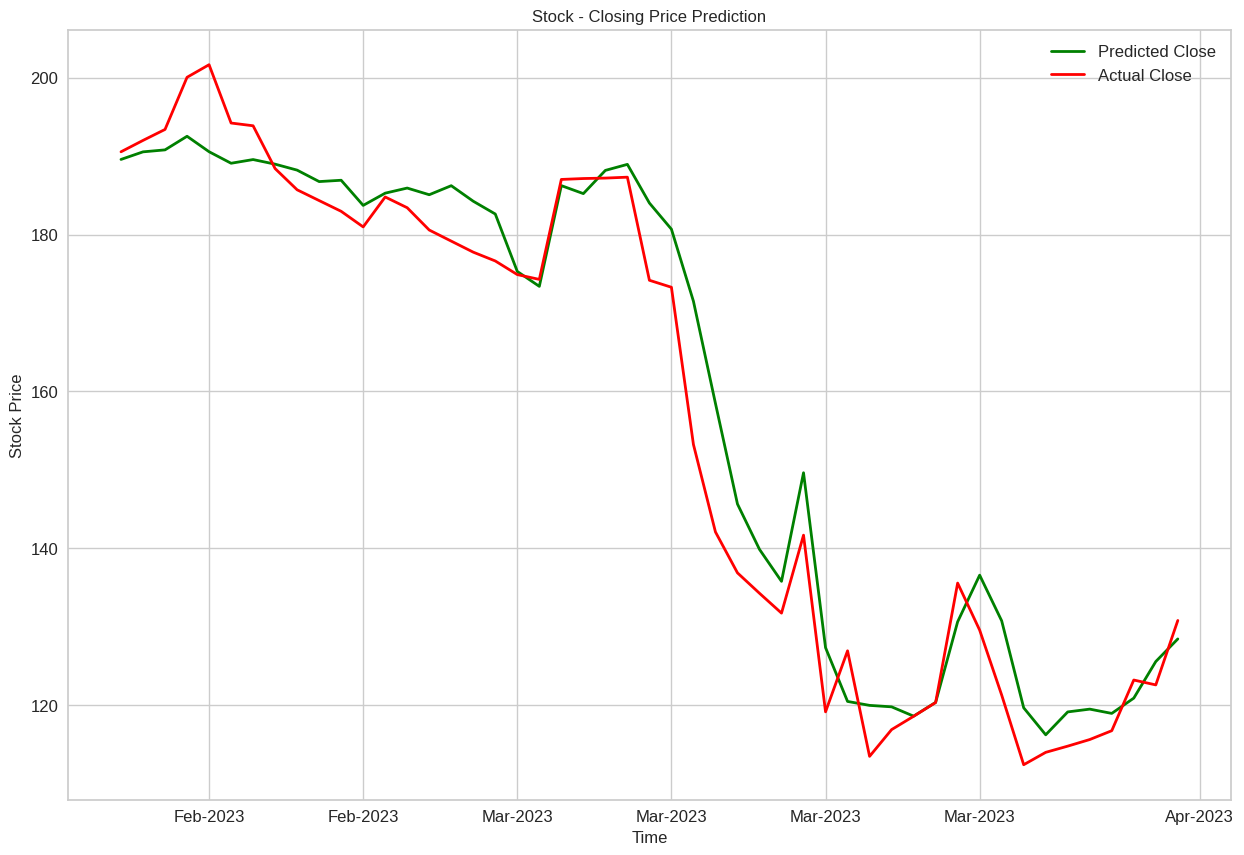

======FINISHED WORKING ON MS======
======CURRENTLY WORKING ON GOOGL======


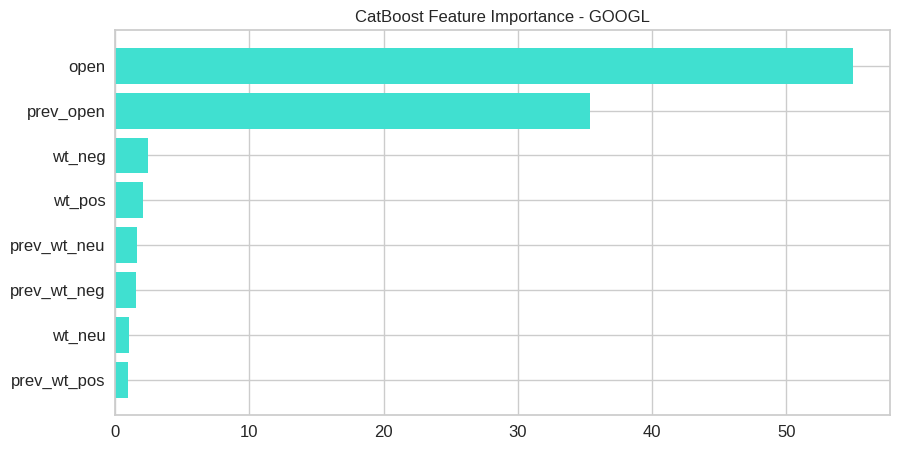

RMSE:			0.049083
MSE:			0.002409
MAE:			0.040237
R2 Score:		0.858421
Adj. R2 Score:		0.852265
Exp. Variance Score:	0.861306
Max Error:		0.135830
Predicted 	 Value
[0.32792996] 	 [0.28874513]
[0.30418844] 	 [0.28900387]
[0.32421554] 	 [0.28926262]
[0.30114481] 	 [0.29107372]
[0.29484512] 	 [0.34954725]
[0.30691451] 	 [0.31254855]
[0.30906134] 	 [0.28253551]
[0.29766572] 	 [0.24941784]
[0.26890446] 	 [0.23285898]
[0.27072536] 	 [0.22457955]
[0.24904592] 	 [0.21630014]
[0.20962886] 	 [0.21267792]
[0.19119595] 	 [0.19301419]
[0.17885934] 	 [0.14747728]
[0.14712341] 	 [0.15705044]
[0.14684389] 	 [0.16196636]
[0.14203046] 	 [0.16662361]
[0.14000612] 	 [0.1715394]
[0.14054275] 	 [0.17930144]
[0.14329908] 	 [0.22173349]
[0.20485531] 	 [0.26442436]
[0.24012032] 	 [0.28357049]
[0.26309288] 	 [0.29314358]
[0.28165571] 	 [0.30271659]
[0.31295204] 	 [0.26985771]
[0.28901547] 	 [0.27994824]
[0.29234605] 	 [0.23001292]
[0.24354378] 	 [0.18628711]
[0.18539857] 	 [0.19249676]
[0.156967] 	 [0.19560154]


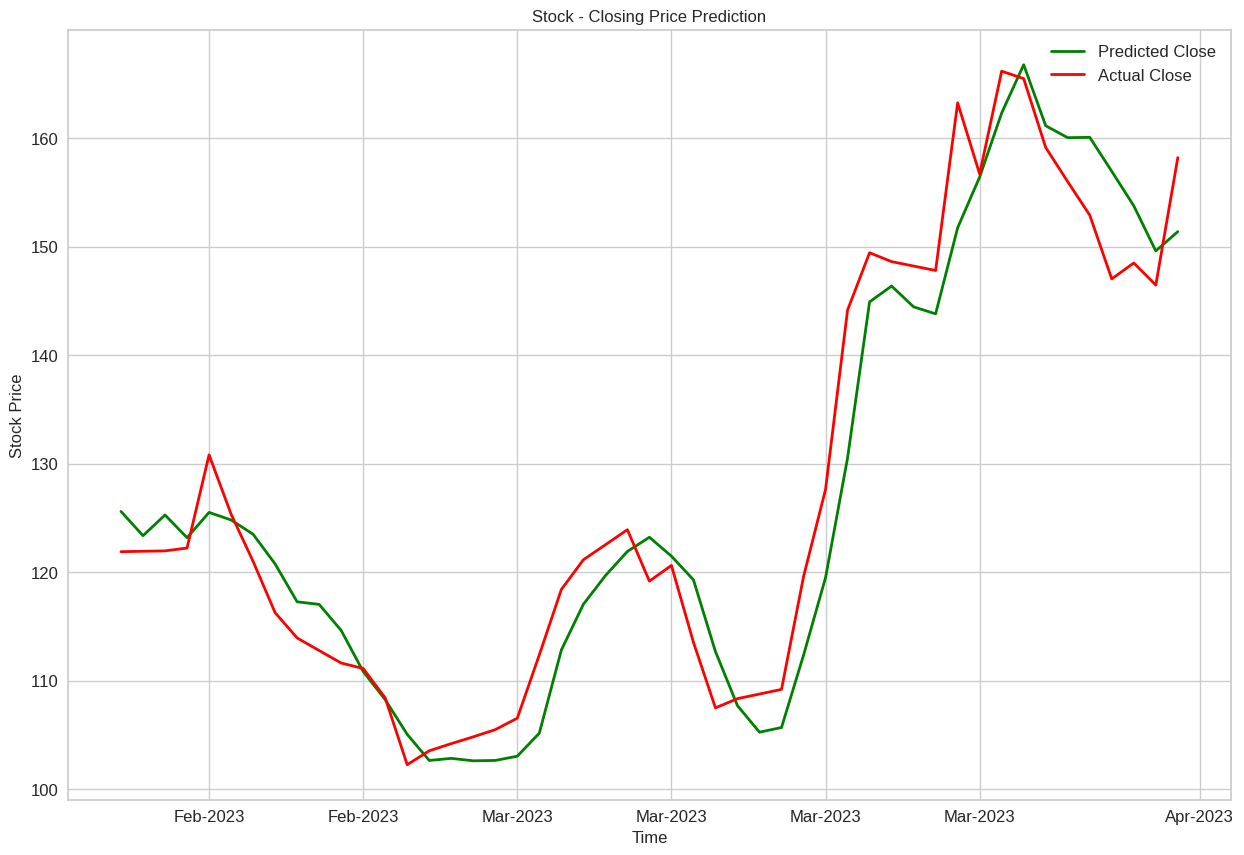

======FINISHED WORKING ON GOOGL======


In [82]:
unscaled_op_labels = get_unscaled_output_labels(categories, tickers, both_open_dfs, output_label='close')
train_and_test_model(categories, tickers, both_open_norm_dfs, unscaled_op_labels)